In [1]:
import sys, os

import matplotlib  
matplotlib.use('Agg')  

from matplotlib.pyplot import savefig
from matplotlib import pyplot as plt

%matplotlib inline

import cobra
import cobra.io
from cobra import Model, Reaction, Metabolite
from cobra.io.sbml import create_cobra_model_from_sbml_file
from cobra.io.sbml import write_cobra_model_to_sbml_file

# Panda python module for dataframe and data storage/manipulation
import pandas as pd
pd.set_option('mode.use_inf_as_null',True)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import seaborn as sns
sns.set(style="white")
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = sns.color_palette("Set2", 10)
b1, b2, b3, b4, b5, b6 = sns.color_palette("Blues")

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

import numpy as np
from copy import deepcopy
import scipy.io
import scipy.sparse as sparse
import random as rand

print "I'm using scipy version:" 
scipy.__version__


I'm using scipy version:


'0.13.3'

In [84]:
#### self-defined functions to find fluxes shifted between different sampling distributions
#from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
#from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore

import fluxShift
reload(fluxShift)
from fluxShift import remove_unwanted_rxns,prune_mcmc_fluxes,get_mean_std_pvalue,plot_rxn_shifts_all_strains,gen_rxn_to_subsystem
from fluxShift import gen_rxn_to_genes,classify_flux_change,find_flux_shifts,get_zscore,get_met_zscore


In [3]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']
coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient1[i]}) 

    reaction.gene_reaction_rule = ''
model.add_reaction(reaction)

react_id = "BiomassProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Biomass protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient2[i]}) 

model.add_reaction(reaction)

In [4]:
print len(model.reactions)

2786


In [5]:
print len(model.metabolites)

1973


In [9]:
from collections import defaultdict

def mcmc_tab2pandas(strain):
    if strain == 'Control' or strain == '20aas':
        file1 = 'sampling_%s_p1.tab'%strain
        file2 = 'sampling_%s_p2.tab'%strain      
    else:
        file1 = 'sampling_Control_%s.tab'%strain
        file2 = 'sampling_20aas_%s.tab'%strain
    
    flux_dist1 = np.loadtxt(file1,delimiter="\t",skiprows=1)
    flux_dist2 = np.loadtxt(file2,delimiter="\t",skiprows=1)

    print "Sample size for %s I:"%strain, flux_dist1.shape
    print "Sample size for %s II:"%strain, flux_dist2.shape
    
    # now convert flux_dist array into pandas df with reaction field
    
    model_rxns=[]

    samples1 = defaultdict(list)
    samples2 = defaultdict(list)
    
    tmp_array = []
    for react in model.reactions:
        tmp_array.append(react.id)

    count = 0
    for i in tmp_array:
        rxn_name = str(i)
        model_rxns.append(str(i))
    
        samples1[rxn_name] = flux_dist1[count,:]
        samples2[rxn_name] = flux_dist2[count,:]
    
        count +=1

    # convert to dataframes    
    df_samples1 = pd.DataFrame(samples1) 
    df_samples2 = pd.DataFrame(samples2)  

    print "number of reactions in df:", len(model_rxns)

    return (df_samples1,df_samples2)

################################################################################


In [10]:
mcmc_p1_dict = {}
mcmc_p2_dict = {}
mylegend = ["Control","20aas"]

for strain in mylegend:
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain]) = mcmc_tab2pandas(strain)


Sample size for Control I: (2786, 5000)
Sample size for Control II: (2786, 5000)
number of reactions in df: 2786
Sample size for 20aas I: (2786, 5000)
Sample size for 20aas II: (2786, 5000)
number of reactions in df: 2786


In [11]:
m = model
m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0
m.reactions.EX_glc__D_e.lower_bound = -0.5

# Find Loops/zero flux reactions in M model
loops = []
read_to_struct =[]
for r in m.reactions:
    r.objective_coefficient = 1.0  
    m.optimize()
    if m.solution.f > 100:
        read_to_struct.append({'reaction':r.id, 'flux':m.solution.f})
        loops.append(r.id)
    
    r.objective_coefficient = 0

DF_erroneous_fluxes = pd.DataFrame(read_to_struct)

print "Finished 1"
#  search for zero flux reactions

opt_fract = 0.9

from cobra.flux_analysis.variability import flux_variability_analysis
flux_var = flux_variability_analysis(m, fraction_of_optimum=opt_fract)

removed = []
read_to_struct = []

for r in m.reactions:
    # 1 fix numerical errors
    if flux_var[r.id]['minimum'] > flux_var[r.id]['maximum']:
        min_val = np.round(flux_var[r.id]['minimum'],9)
        max_val = np.round(flux_var[r.id]['maximum'],9)
        flux_var[r.id]['minimum'] = max_val
        flux_var[r.id]['maximum'] = min_val
        
    # 2 constrain bounds to FVA results
    r.lower_bound = flux_var[r.id]['minimum']
    r.upper_bound = flux_var[r.id]['maximum']
    
    # 3 remove reactions that cannot carry flux
    if r.lower_bound==0 and r.upper_bound==0:
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 1
        m.optimize()
        
        if m.solution.f == None:
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'no'})
        else:
            removed.append(r.id)
            m.remove_reactions(r)
            read_to_struct.append({'reaction':r.id, 'solution':m.solution.f, 'removed?':'yes'})
            
        m.reactions.BIOMASS_Ec_iJO1366_core_53p95M.objective_coefficient = 0   
        
DF_zero_flux_reactions = pd.DataFrame(read_to_struct)


Finished 1


cobra/core/Model.py:306 UserWarning: need to pass in a list


In [12]:
## Remove reactions from sampling dataframes
reactions_to_remove = DF_zero_flux_reactions.reaction[DF_zero_flux_reactions['removed?']=='yes'].tolist() + DF_erroneous_fluxes.reaction.tolist()
print "number of total reactions:", len(DF_zero_flux_reactions[DF_zero_flux_reactions['removed?']=='yes'])+len(DF_erroneous_fluxes.reaction)


number of total reactions: 750


In [13]:
mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}


In [14]:
for strain in mylegend:
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    #df_reduced_p3 = remove_unwanted_rxns(mcmc_p3_dict[strain])

    ## testing
    # df_reduced_p1 = remove_unwanted_rxns(df_p1_samples,reactions_to_remove)
    # df_reduced_p2 = remove_unwanted_rxns(df_p2_samples,reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    #mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    #print "Strain", strain, shape(mcmc_reduced_dict_p3[strain])


Strain Control (5000, 2036)
Strain Control (5000, 2036)
Strain 20aas (5000, 2036)
Strain 20aas (5000, 2036)


In [15]:
react = 'EX_glc__D_e'
mcmc_reduced_dict_p1['20aas'][react]


0    -1.61
1    -1.61
2    -1.61
3    -1.61
4    -1.61
5    -1.61
6    -1.61
7    -1.61
8    -1.61
9    -1.61
10   -1.61
11   -1.61
12   -1.61
13   -1.61
14   -1.61
...
4985   -1.61
4986   -1.61
4987   -1.61
4988   -1.61
4989   -1.61
4990   -1.61
4991   -1.61
4992   -1.61
4993   -1.61
4994   -1.61
4995   -1.61
4996   -1.61
4997   -1.61
4998   -1.61
4999   -1.61
Name: EX_glc__D_e, Length: 5000, dtype: float64

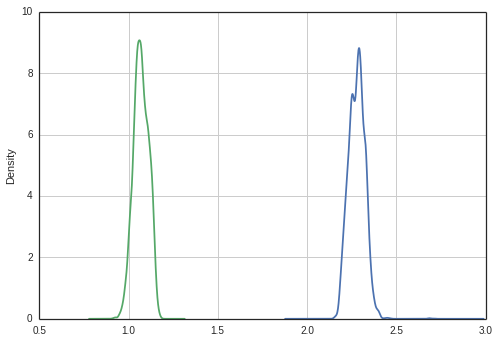

In [17]:
react = 'ENO'

mcmc_reduced_dict_p1['20aas'][react].plot(kind='density')
mcmc_reduced_dict_p2['20aas'][react].plot(kind='density')

savefig('ENO.jpg')

In [18]:
#########################################################

# Perform further pruning of flux distributions
# Note: none of the remaining reactions have a significant amount of fluxes above the threshold:
#       No reactions have fluxes greater than 10 x glc uptake for > 99% of flux states
#       No reactions have fluxes greater than 20 x glc uptake

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}

for strain in mcmc_reduced_dict_p1.keys():

    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape


shape before pruning Control: (5000, 2036)
shape after pruning Control: (5000, 2002)
shape before pruning Control: (5000, 2036)
shape after pruning Control: (5000, 2005)
shape before pruning 20aas: (5000, 2036)
shape after pruning 20aas: (5000, 2005)
shape before pruning 20aas: (5000, 2036)
shape after pruning 20aas: (5000, 2005)


In [19]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['20aas']

for i in df.index:
    if df['percent of states with flux < 10'][i] < 9900:
        print df['react_id'][i], df['percent of states with flux < 10'][i]

for i in df.index:
    if df['percent of states with flux < 10'][i] <10000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]


2HH24DDH1_copy2 0
ACKr 0
ACt2rpp 0
ALAt2pp_copy2 0
ASPt2pp_copy2 65
ATPS4rpp 1
CAt6pp 0
CRNt2rpp 0
CYTDt2pp_copy2 0
EX_fe2_e 3
EX_h_e 56
FE3tex 3
GLUt2rpp 0
GLYBt2pp_copy2 0
GLYCLTt2rpp 257
GLYt2pp_copy2 0
H2Otex 3
HPYRI 0
ICHORS_copy1 0
INSTt2 0
PPKr 0
PPM 0
PRASCSi_copy2 0
PROt2rpp 416
PRPPS 0
SERt2rpp 233
SUCOAS 0
THRt2rpp 419
TRSARr 0
URAt2pp_copy2 0
URIt2pp_copy2 0
2HH24DDH1_copy2 999.011343731
ACKr 934.267572535
ACt2rpp 764.665931974
ALAt2pp_copy2 999.998950915
ASPt2pp_copy2 763.145069866
CAt6pp 844.776148218
CRNt2rpp 975.228476759
CYTDt2pp_copy2 999.951812088
EX_fe2_e 21.9530801544
EX_h_e 20.7590460195
FE3tex 22.0425597579
GLUt2rpp 804.287313886
GLYBt2pp_copy2 999.973007474
GLYCLTt2rpp 232.542168277
GLYt2pp_copy2 999.999734474
HPYRI 993.755727614
ICHORS_copy1 816.523781402
INSTt2 678.424642888
PPKr 999.996008128
PPM 369.192972633
PRASCSi_copy2 999.983827269
PROt2rpp 175.595620223
PRPPS 368.883143099
SERt2rpp 427.079163355
SUCOAS 964.580739344
THRt2rpp 175.599288819
TRSARr 993.75

In [20]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given strain
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1_p2 = {}
#flux_stats_dict_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        flux_stats_dict_p1_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain], m, 1, 2)
        #flux_stats_dict_p2_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain], m, 2, 3)

# Note: here we have the mean, median and std for the flux distributions in phases 1 and 2.
# The pval indicates whether the sample difference between these two states is significant.
flux_stats_dict_p1_p2['20aas'][0:3]


strain: Control
strain: 20aas


,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,2.62e-05,2.62e-05,6.01e-07,8.19e-06,8.19e-06,3.09e-07,8.00e-04,DM_4crsol_c
1,1.98e-04,1.56e-04,1.46e-04,1.42e-04,1.09e-04,1.19e-04,7.66e-01,DM_5drib_c
2,2.35e-07,2.35e-07,5.39e-09,7.35e-08,7.35e-08,2.77e-09,8.00e-04,DM_amob_c


In [21]:
mcmc_reduced_dict_p1['Control']['2AGPEAT181']

0    -2.98e-06
1     9.73e-04
2     9.74e-04
3     9.70e-04
4     2.21e-03
5     2.21e-03
6     7.39e-03
7     7.40e-03
8     7.37e-03
9     7.37e-03
10    6.24e-03
11    7.07e-04
12    6.63e-04
13    6.61e-04
14    5.52e-04
...
4985    0.03
4986    0.03
4987    0.03
4988    0.03
4989    0.03
4990    0.02
4991    0.02
4992    0.03
4993    0.03
4994    0.03
4995    0.03
4996    0.04
4997    0.04
4998    0.02
4999    0.02
Name: 2AGPEAT181, Length: 5000, dtype: float64

6-phosphogluconolactonase
['Control', '20aas']
(5000, 2002)


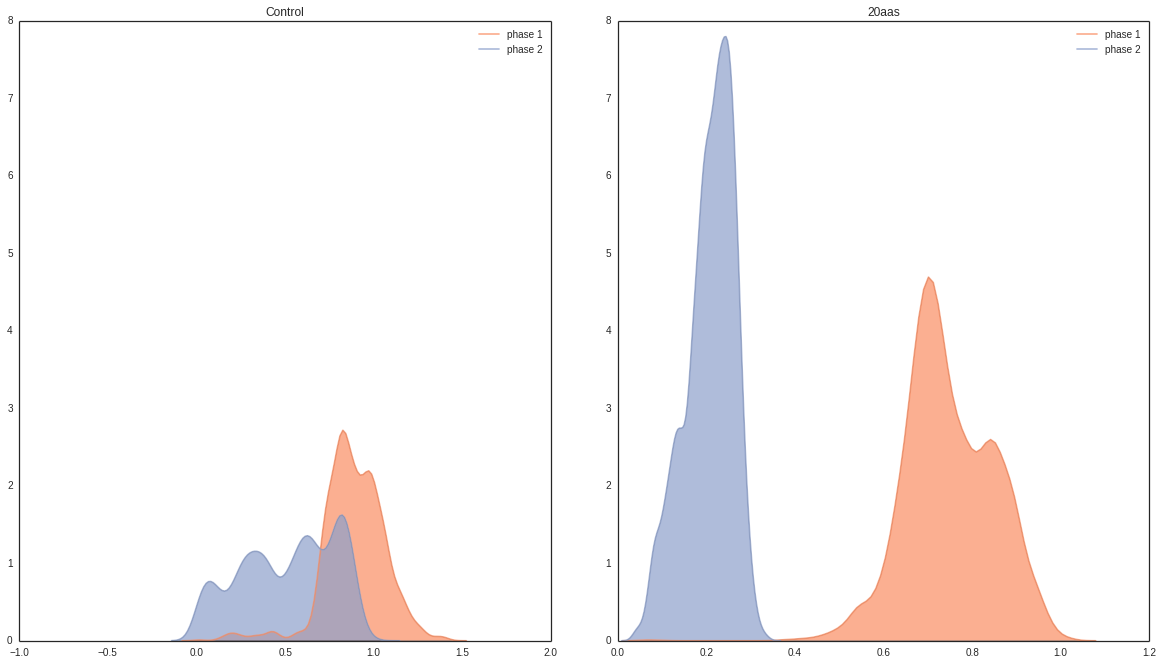

In [27]:
# Plot Shifts

react = 'PGL'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 2, -1, 8)


In [28]:
# Classify Flux 
flux_stats_dict_p1_p2['20aas'][0:1]

flux_shift_stats_dict ={}
m_significant_shifts_dict ={}

for strain in flux_stats_dict_p1_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p1_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict[strain] = df
    m_significant_shifts_dict[strain] = change
    
print m_significant_shifts_dict['20aas'].reaction.values

m_significant_shifts_dict['20aas'].subsystem.value_counts()


strain: Control
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1626
do shift 29 

strain: 20aas
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1619
do shift 33 

['ACONTa' 'ACONTb' 'AKGDH' 'ASPTA' 'CS' 'ENO' 'FBA' 'FRD2' 'FUM' 'G6PDH2r'
 'GAPD' 'GLNS' 'GLUDy' 'GND' 'HCO3E' 'ICDHyr' 'MDH' 'PDH' 'PFK' 'PGCD'
 'PGI' 'PGK' 'PGM' 'PPC' 'PSERT' 'PSP_L' 'RPE' 'RPI' 'SUCDi' 'TKT1' 'TKT2'
 'TPI' 'PGL']


Glycolysis/Gluconeogenesis          9
Citric Acid Cycle                   8
Pentose Phosphate Pathway           7
Glycine and Serine Metabolism       3
Glutamate Metabolism                2
Anaplerotic Reactions               1
Alanine and Aspartate Metabolism    1
Oxidative Phosphorylation           1
Unassigned                          1
dtype: int64

In [29]:
print m_significant_shifts_dict['Control'].reaction.values

m_significant_shifts_dict['Control'].subsystem.value_counts()

['ACCOAC' 'ACONTa' 'ACONTb' 'AKGDH' 'ASPTA' 'CS' 'ENO' 'FBA3' 'FRD2' 'FRD3'
 'FUM' 'GAPD' 'GLNS' 'GLUDy' 'HCO3E' 'ICDHyr' 'MCOATA' 'MDH' 'PDH' 'PFK_3'
 'PGCD' 'PGK' 'PGM' 'PSERT' 'PSP_L' 'RPI' 'SUCDi' 'TALA' 'TPI']


Citric Acid Cycle                   9
Glycolysis/Gluconeogenesis          6
Pentose Phosphate Pathway           4
Glycine and Serine Metabolism       3
Glutamate Metabolism                2
Membrane Lipid Metabolism           2
Oxidative Phosphorylation           1
Unassigned                          1
Alanine and Aspartate Metabolism    1
dtype: int64

Mean: 0.0376285267589
Median: 0.00073
std: 0.35079404595
Factor x chosen: 0.5
Threshold up (mean + x*std):  0.213025549734
Threshold down (mean - x*std): -0.137768496216
Percent of population above/below threshold: 0.0240529164161


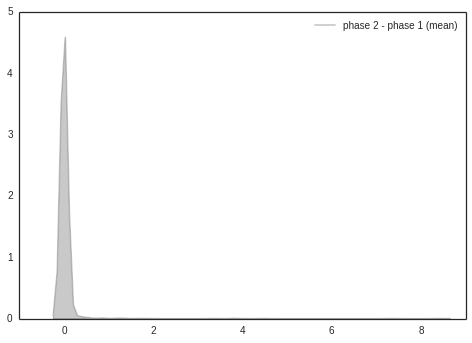

In [30]:
#note: this is how i chose the threshold for flux differences (mean vs kde)
series = abs(flux_shift_stats_dict['20aas'].p2mean - flux_shift_stats_dict['20aas'].p1mean)
#series.plot(kind='kde')
sns.kdeplot(series, shade=True, color=c8, alpha=0.7,label='phase 2 - phase 1 (mean)')

series = abs(flux_shift_stats_dict['20aas'].p2mean - flux_shift_stats_dict['20aas'].p1mean)

factor_up = .5
factor_down = .5

print "Mean:", series.mean()
print "Median:", series.median()
print "std:", series.std()
print "Factor x chosen:", factor_up
print "Threshold up (mean + x*std): ", series.mean() + factor_up*series.std()
print "Threshold down (mean - x*std):", series.mean() - factor_down*series.std()
print "Percent of population above/below threshold:", np.true_divide(series[series > series.mean() + factor_up*series.std()].count() + series[series < series.mean() - factor_up*series.std()].count(), len(series))


In [32]:
# Compute Z score per reaction difference between phases
DF_reaction_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        DF_reaction_zscore[strain] = get_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict,strain)
        
DF_reaction_zscore['20aas'][0:10]


***PROGRESS: 2133/2134 reactions***



,reaction,z_score
0,DM_4crsol_c,0.11
1,DM_5drib_c,0.11
2,DM_amob_c,0.11
3,DM_mththf_c,0.11
4,DM_oxam_c,0.10
5,BIOMASS_Ec_iJO1366_WT_53p95M,0.11
6,BIOMASS_Ec_iJO1366_core_53p95M,0.12
7,EX_12ppd__R_e,0.10
8,EX_12ppd__S_e,0.10
9,EX_15dap_e,0.11


In [33]:
# Compute met Z scores
DF_metabolite_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_metabolite_zscore[strain] = get_met_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m, flux_shift_stats_dict, DF_reaction_zscore, strain)
         
DF_metabolite_zscore['20aas'][0:10]


***PROGRESS: 1667/1973 metabolites***



,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.07
1,12dgr120_c,3,0.15
2,12dgr140_c,3,0.17
3,12dgr141_c,3,0.17
4,12dgr160_c,3,0.16
5,12dgr161_c,3,0.17
6,12dgr180_c,3,0.16
7,12dgr181_c,3,0.17
8,12ppd__R_c,3,0.09
9,12ppd__S_c,2,0.14


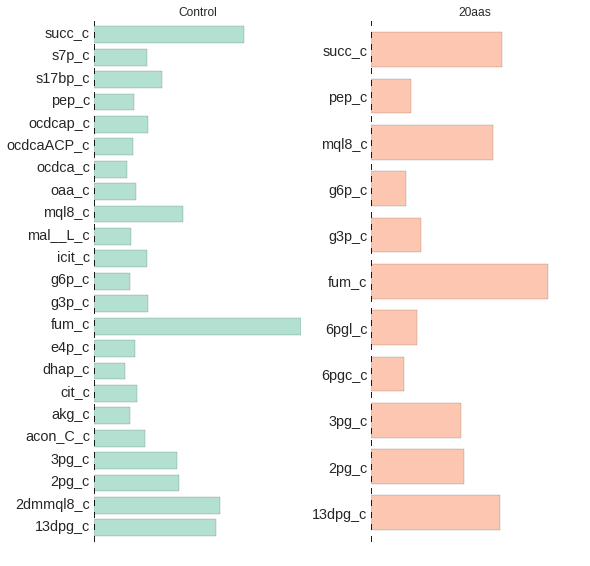

In [39]:
from matplotlib import pyplot as plt

metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'Metabolite_zscores_phases'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis

c1, c2 = sns.color_palette("Set2", 2)

strain = "Control"
df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.74]

df.zscore.plot(ax=axes[0], kind='barh', color=c1, title='Control',alpha=0.5,figsize=(5, 8))

axes[0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = '20aas'

df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.74]

df.zscore.plot(ax=axes[1], kind='barh', color=c2, title='20aas',alpha=0.5,figsize=(5, 8))
axes[1].axis('off')
for i, x in enumerate(df.metabolite):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(8)
fig.set_figheight(8)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


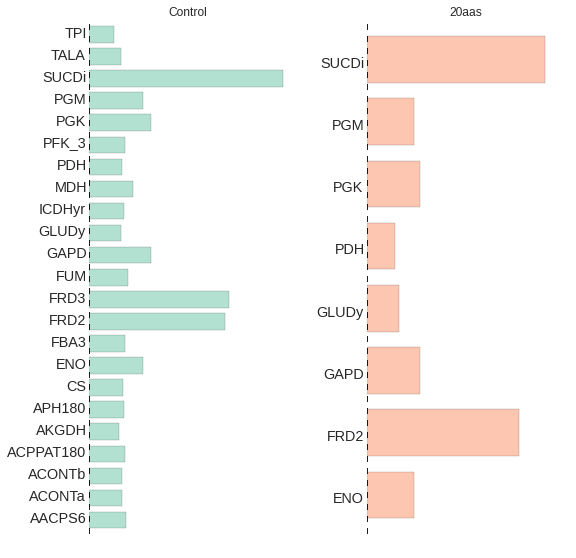

In [40]:
##########################################################
name_graph = 'Reaction_zscores_phases'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis
c1, c2 = sns.color_palette("Set2", 2)

strain = "Control"
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74]
    
#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[0], kind='barh', color=c1, title=strain,alpha=0.5,figsize=(5, 7))
axes[0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = '20aas'
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74]

#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[1], kind='barh', color=c2, title=strain,alpha=0.5,figsize=(5, 7))
axes[1].axis('off')
for i, x in enumerate(df.reaction):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')
     
fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(8)
fig.set_figheight(8)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


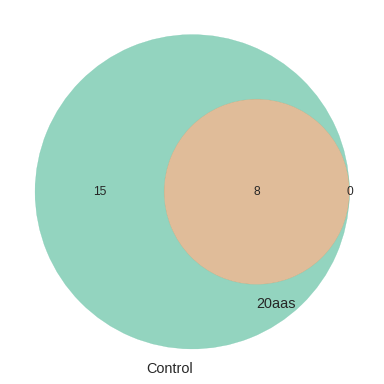

In [41]:
## Veen figures

from matplotlib_venn import venn2, venn2_circles

name_graph = 'Overlaps_reaction_z_score'

#fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis
fig = plt.figure()
c1, c2 = sns.color_palette("Set2", 2)


ax1=fig.add_subplot(1,1,1)

strain = 'Control'
set1 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74].tolist()
set1 = set(set1)

strain = '20aas'
set2 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74].tolist()
set2 = set(set2)

v = venn2([set1, set2], ('Control', '20aas'),ax=ax1)
v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('100').set_color(c1)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('010').set_color(c2)

ax1.axis('off')

fig.tight_layout()
fig = plt.gcf()

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

In [42]:
model = cobra.io.load_json_model("HNC47.json")
react_id = "RecombinantProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Recombinant protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0

metabolites = ['ala__L_c','cys__L_c','asp__L_c','glu__L_c','phe__L_c','gly_c','his__L_c','ile__L_c','lys__L_c','leu__L_c','met__L_c','asn__L_c','pro__L_c','gln__L_c','arg__L_c','ser__L_c','thr__L_c','val__L_c','trp__L_c','tyr__L_c','atp_c','adp_c','pi_c']
coefficient1 = [-6,-6,-9,-17,-9,-11,-5,-4,-17,-17,-3,-11,-19,-11,-6,-24,-14,-23,-4,-8,-4.306*224,964.544,965.544]
coefficient2 = [-0.513689,-0.09158,-0.241055,-0.26316,-0.185265,-0.612638,-0.094738,-0.290529,-0.343161,-0.450531,-0.153686,-0.241055,-0.221055,-0.26316,-0.295792,-0.215792,-0.253687,-0.423162,-0.056843,-0.137896,-23.03053,23.03053,23.03053]
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient1[i]}) 

    reaction.gene_reaction_rule = ''
model.add_reaction(reaction)

react_id = "BiomassProtein"
reaction = Reaction(react_id)
reaction.name = react_id
reaction.subsystem = "Biomass protein synthesis"
reaction.lower_bound = 0
reaction.upper_bound = 1000
reaction.objective_coefficient = 0
for i in range(0,len(metabolites)):
    metabolite = model.metabolites.get_by_id(metabolites[i])
    reaction.add_metabolites({metabolite:coefficient2[i]}) 

model.add_reaction(reaction)

In [46]:
#################################################
#
## flux shift identifying between different culture conditions for a given phase
#

mcmc_reduced_dict_p1 = {}
mcmc_reduced_dict_p2 = {}

mcmc_p1_dict = {}
mcmc_p2_dict = {}

mylegend = ['p1','p2'] # deal with flux shift identifying between different culture conditions

for strain in mylegend:
    (mcmc_p1_dict[strain],mcmc_p2_dict[strain]) = mcmc_tab2pandas(strain)
    df_reduced_p1 = remove_unwanted_rxns(mcmc_p1_dict[strain],reactions_to_remove)
    df_reduced_p2 = remove_unwanted_rxns(mcmc_p2_dict[strain],reactions_to_remove)
    
    mcmc_reduced_dict_p1[strain] = df_reduced_p1
    mcmc_reduced_dict_p2[strain] = df_reduced_p2
    #mcmc_reduced_dict_p3[strain] = df_reduced_p3
    
    print "Strain", strain, mcmc_reduced_dict_p1[strain].shape
    print "Strain", strain, mcmc_reduced_dict_p2[strain].shape
    #print "Strain", strain, shape(mcmc_reduced_dict_p3[strain])



Sample size for p1 I: (2786, 5000)
Sample size for p1 II: (2786, 5000)
number of reactions in df: 2786
Strain p1 (5000, 2036)
Strain p1 (5000, 2036)
Sample size for p2 I: (2786, 5000)
Sample size for p2 II: (2786, 5000)
number of reactions in df: 2786
Strain p2 (5000, 2036)
Strain p2 (5000, 2036)


In [56]:
print len(m.reactions)

2134


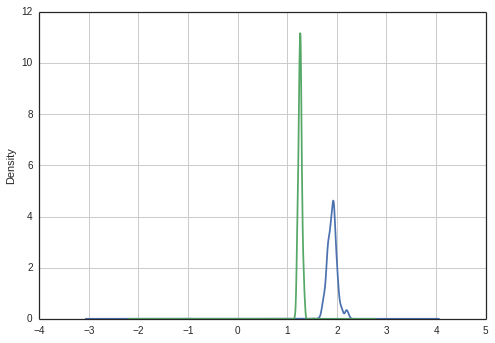

In [88]:
## Example of how to access flux distributions from data

react = 'CS'

mcmc_reduced_dict_p1['p1'][react].plot(kind='density')
mcmc_reduced_dict_p2['p1'][react].plot(kind='density')

savefig('CS.jpg')

In [48]:
react = 'EX_glc__D_e'
mcmc_reduced_dict_p2['p1'][react]

0    -1.61
1    -1.61
2    -1.61
3    -1.61
4    -1.61
5    -1.61
6    -1.61
7    -1.61
8    -1.61
9    -1.61
10   -1.61
11   -1.61
12   -1.61
13   -1.61
14   -1.61
...
4985   -1.61
4986   -1.61
4987   -1.61
4988   -1.61
4989   -1.61
4990   -1.61
4991   -1.61
4992   -1.61
4993   -1.61
4994   -1.61
4995   -1.61
4996   -1.61
4997   -1.61
4998   -1.61
4999   -1.61
Name: EX_glc__D_e, Length: 5000, dtype: float64

In [49]:

df_rxns_removed_p1 = {}
df_rxns_removed_p2 = {}

df_rxns_high_flux_remain_p1 = {}
df_rxns_high_flux_remain_p2 = {}

for strain in mcmc_reduced_dict_p1.keys():
    
    print "shape before pruning %s:"%strain,mcmc_reduced_dict_p1[strain].shape 
    [mcmc_reduced_dict_p1[strain], df_rxns_removed_p1[strain], df_rxns_high_flux_remain_p1[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p1[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p1[strain].shape
    
    print "shape before pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape
    [mcmc_reduced_dict_p2[strain], df_rxns_removed_p2[strain], df_rxns_high_flux_remain_p2[strain]] = prune_mcmc_fluxes(mcmc_reduced_dict_p2[strain],m)
    print "shape after pruning %s:"%strain, mcmc_reduced_dict_p2[strain].shape


shape before pruning p2: shape after pruning p2: (5000, 2005)
shape before pruning p2: (5000, 2036)
shape after pruning p2: (5000, 2005)
shape before pruning p1: shape after pruning p1: (5000, 2002)
shape before pruning p1: (5000, 2036)
shape after pruning p1: (5000, 2005)


In [50]:
# QC/QA of pruning flux states

df = df_rxns_removed_p1['p1']

for i in df.index:
    if df['percent of states with flux < 10'][i] < 9900:
        print df['react_id'][i], df['percent of states with flux < 10'][i]

for i in df.index:
    if df['percent of states with flux < 10'][i] <10000:  
        if df['max abs flux'][i] > 20:
            print df['react_id'][i],df['max abs flux'][i]


2HH24DDH1_copy2 0
ACKr 0
ACt2rpp 0
ALAt2pp_copy2 0
ASPt2pp_copy2 313
ATPS4rpp 0
CAt6pp 0
CRNt2rpp 0
CYTBO3_4pp 1
CYTDt2pp_copy2 0
EX_fe2_e 3114
EX_h_e 3735
FE3tex 2894
GLUt2rpp 0
GLYBt2pp_copy2 0
GLYCLTt2rpp 0
GLYt2pp_copy2 0
H2Otex 0
H2Otpp 1222
HPYRI 0
ICHORS_copy1 0
INSTt2 0
PPKr 0
PPM 4
PRASCSi_copy2 0
PROt2rpp 0
PRPPS 5
SERt2rpp 110
SUCDi 2200
SUCOAS 0
THRt2rpp 44
TRSARr 0
URAt2pp_copy2 0
URIt2pp_copy2 0
2HH24DDH1_copy2 999.979358334
ACKr 942.602410089
ACt2rpp 999.434592531
ALAt2pp_copy2 999.999884454
ASPt2pp_copy2 790.375537332
ATPS4rpp 21.4767603969
CAt6pp 999.992884503
CRNt2rpp 999.451680938
CYTDt2pp_copy2 999.907810864
GLUt2rpp 999.999848702
GLYBt2pp_copy2 991.878464307
GLYCLTt2rpp 980.506477163
GLYt2pp_copy2 999.999883532
HPYRI 991.839081194
ICHORS_copy1 988.806440262
INSTt2 970.581808691
PPKr 999.993699937
PPM 358.523988056
PRASCSi_copy2 999.893961479
PROt2rpp 978.808229672
PRPPS 357.938491673
SERt2rpp 870.305601868
SUCOAS 953.170768328
THRt2rpp 245.060955684
TRSARr 991.8390

In [51]:
## get means and std's for two states and their corresponding pval for significant overlap
# this box runs through two phases and gets the changes between phase1- phase2 for a given culture conditions
# or, between culture conditions1 - culture conditions2 for a given phase
#**** note, check that reduced and full sets have same distributions

flux_stats_dict_p1_p2 = {}
#flux_stats_dict_p2_p3 = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        flux_stats_dict_p1_p2[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain], m, 1, 2)
        #flux_stats_dict_p2_p3[strain] = get_mean_std_pvalue(mcmc_reduced_dict_p2[strain],mcmc_reduced_dict_p3[strain], m, 2, 3)

# Note: here we have the mean, median and std for the flux distributions in phases 1 and 2.
# The pval indicates whether the sample difference between these two states is significant.
flux_stats_dict_p1_p2['p1'][0:3]


strain: p2
strain: p1


,p1mean,p1median,p1std,p2mean,p2median,p2std,pval,reaction
0,1.90e-05,1.90e-05,4.22e-07,2.62e-05,2.62e-05,6.01e-07,8.00e-04,DM_4crsol_c
1,4.73e-04,3.70e-04,3.90e-04,1.98e-04,1.56e-04,1.46e-04,5.00e-01,DM_5drib_c
2,1.70e-07,1.70e-07,3.79e-09,2.35e-07,2.35e-07,5.39e-09,8.00e-04,DM_amob_c


In [53]:
print mcmc_reduced_dict_p2['p1'].shape
print flux_stats_dict_p1_p2['p1'].shape

(5000, 2005)
(2134, 8)


Fumarase
['p2', 'p1']
(5000, 2005)


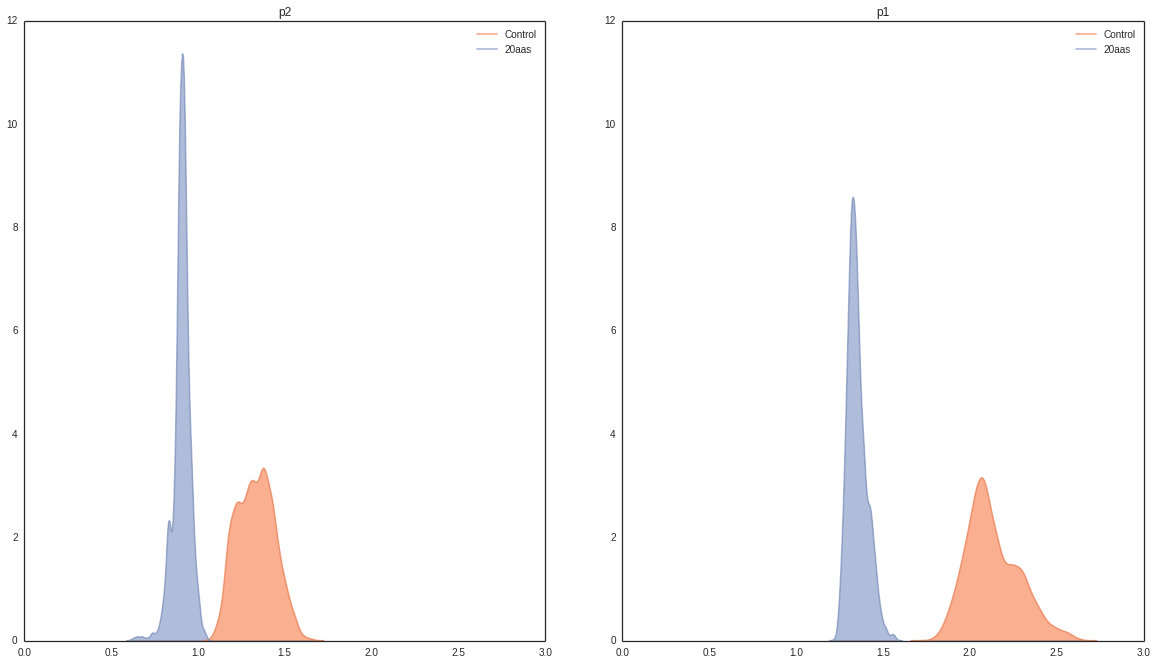

In [85]:
# Plot Shifts

react = 'FUM'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 3, 0, 12)


Aconitase (half-reaction A, Citrate hydro-lyase)
['p2', 'p1']
(5000, 2005)


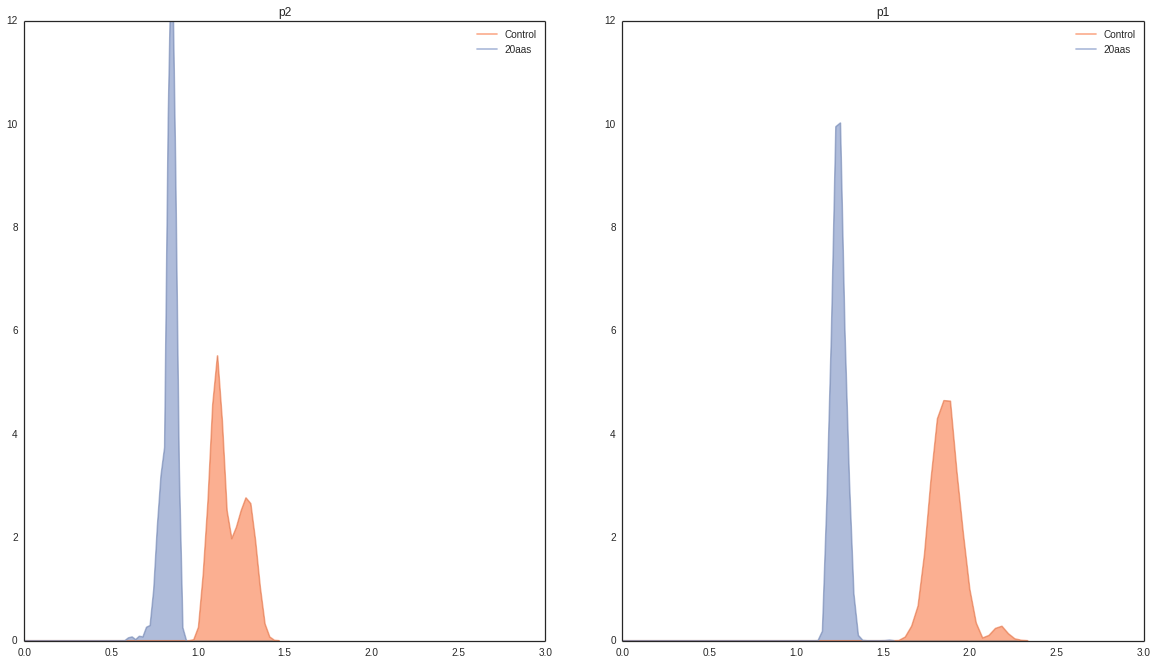

In [86]:
react = 'ACONTa'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 3, 0, 12)


Citrate synthase
['p2', 'p1']
(5000, 2005)


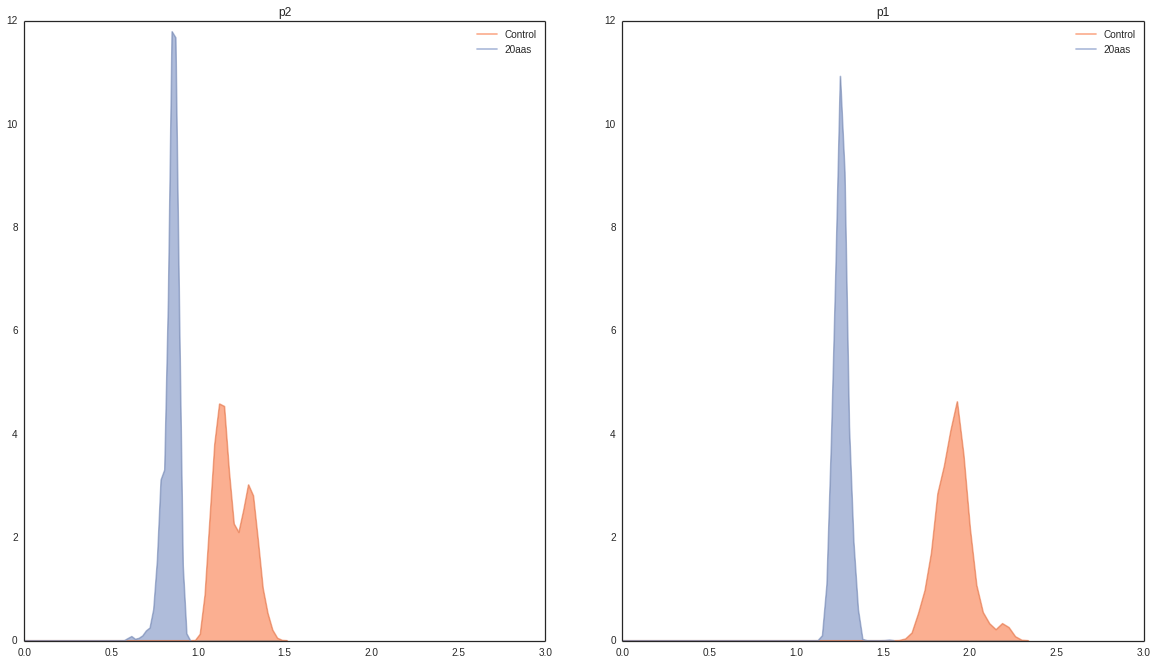

In [87]:
react = 'CS'
print m.reactions.get_by_id(react).name
#plot_rxn_shifts(strain,df, df2, df3, react, 0.1, -0.01, 8)
plot_rxn_shifts_all_strains(mcmc_reduced_dict_p1, mcmc_reduced_dict_p2, react, 3, 0, 12)


In [58]:
# Classify Flux shifts
flux_stats_dict_p1_p2['p1'][0:1]

flux_shift_stats_dict ={}
m_significant_shifts_dict ={}

for strain in flux_stats_dict_p1_p2.keys():
    print "strain:", strain
    df = flux_stats_dict_p1_p2[strain]
    [df,same,change]= find_flux_shifts(df,m,1,2)
    flux_shift_stats_dict[strain] = df
    m_significant_shifts_dict[strain] = change
    
print m_significant_shifts_dict['p1'].reaction.values

m_significant_shifts_dict['p1'].subsystem.value_counts()


strain: p2
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1645
do shift 9 

strain: p1
no. rxns before filtering out exchange rxns: 2134
no. rxns after filtering out exchange rxns: 1663

flux change counts:
dont shift 1641
do shift 13 

['ACONTa' 'ACONTb' 'AKGDH' 'CS' 'CYTK1' 'DRPA' 'FRD3' 'FUM' 'ICDHyr' 'MDH'
 'NDPK3' 'PPM2' 'SUCDi']


Citric Acid Cycle              8
Alternate Carbon Metabolism    2
Nucleotide Salvage Pathway     2
Oxidative Phosphorylation      1
dtype: int64

In [59]:
print m_significant_shifts_dict['p2'].reaction.values

m_significant_shifts_dict['p2'].subsystem.value_counts()


['ACONTa' 'ACONTb' 'AKGDH' 'CS' 'CYTK1' 'FUM' 'GLUDy' 'ICDHyr' 'NDPK3']


Citric Acid Cycle             6
Nucleotide Salvage Pathway    2
Glutamate Metabolism          1
dtype: int64

Mean: 0.0339406494287
Median: 0.00393
std: 0.295774469266
Factor x chosen: 0.5
Threshold up (mean + x*std):  0.181827884062
Threshold down (mean - x*std): -0.113946585204
Percent of population above/below threshold: 0.0192423331329


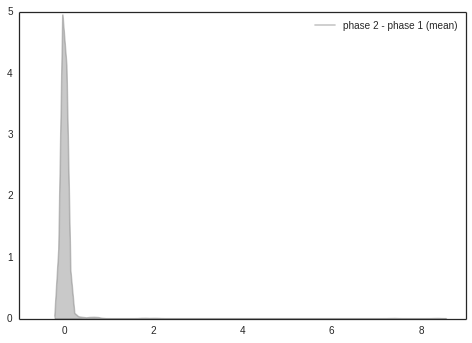

In [66]:
#note: this is how i chose the threshold for flux differences (mean vs kde)
series = abs(flux_shift_stats_dict['p1'].p2mean - flux_shift_stats_dict['p1'].p1mean)
#series.plot(kind='kde')
sns.kdeplot(series, shade=True, color=c8, alpha=0.7,label='phase 2 - phase 1 (mean)')

series = abs(flux_shift_stats_dict['p1'].p2mean - flux_shift_stats_dict['p1'].p1mean)

factor_up = .5
factor_down = .5

print "Mean:", series.mean()
print "Median:", series.median()
print "std:", series.std()
print "Factor x chosen:", factor_up
print "Threshold up (mean + x*std): ", series.mean() + factor_up*series.std()
print "Threshold down (mean - x*std):", series.mean() - factor_down*series.std()
print "Percent of population above/below threshold:", np.true_divide(series[series > series.mean() + factor_up*series.std()].count() + series[series < series.mean() - factor_up*series.std()].count(), len(series))

In [67]:
# Compute Z score per reaction difference

DF_reaction_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_reaction_zscore[strain] = get_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m,flux_shift_stats_dict,strain)
            
DF_reaction_zscore['p1'][0:10]


***PROGRESS: 2133/2134 reactions***



,reaction,z_score
0,DM_4crsol_c,0.11
1,DM_5drib_c,0.11
2,DM_amob_c,0.11
3,DM_mththf_c,0.11
4,DM_oxam_c,0.11
5,BIOMASS_Ec_iJO1366_WT_53p95M,0.11
6,BIOMASS_Ec_iJO1366_core_53p95M,0.01
7,EX_12ppd__R_e,0.10
8,EX_12ppd__S_e,0.11
9,EX_15dap_e,0.11


In [68]:
DF_reaction_zscore['p1'].to_csv("p1_reaction_zscore.csv")
DF_reaction_zscore['p2'].to_csv("p2_reaction_zscore.csv")

In [69]:
# Compute met Z scores
DF_metabolite_zscore = {}

for strain in mcmc_reduced_dict_p1.keys():
        print "strain:", strain
        
        DF_metabolite_zscore[strain] = get_met_zscore(mcmc_reduced_dict_p1[strain],mcmc_reduced_dict_p2[strain],m, flux_shift_stats_dict, DF_reaction_zscore,strain)
         
DF_metabolite_zscore['p1'][0:10]


***PROGRESS: 1667/1973 metabolites***



,metabolite,num_rxns_involved,zscore
0,10fthf_c,7,0.12
1,12dgr120_c,3,0.26
2,12dgr140_c,3,0.26
3,12dgr141_c,3,0.26
4,12dgr160_c,3,0.26
5,12dgr161_c,3,0.26
6,12dgr180_c,3,0.23
7,12dgr181_c,3,0.27
8,12ppd__R_c,3,0.08
9,12ppd__S_c,2,0.12


In [70]:
DF_metabolite_zscore['p1'].to_csv("p1_metabolite_zscore.csv")
DF_metabolite_zscore['p2'].to_csv("p2_metabolite_zscore.csv")

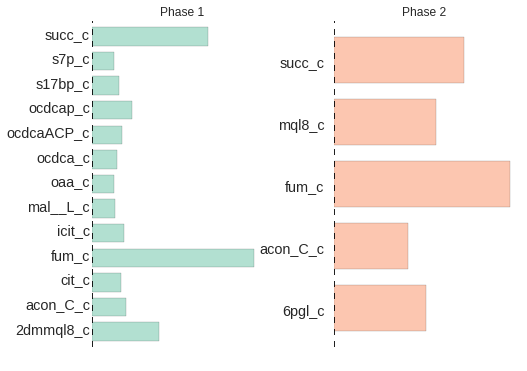

In [90]:
metabolites_to_omit=['mqn8_c','2dmmq8_c','nh4_c','na1_c','zn2_c','ni2_c','q8_c','o2_c','h2o_c','pi_c','nadh_c','nad_c','nadph_c','nadp_c','atp_c','adp_c','amp_c','h_c','coa_c','co2_c','q8h2_c','cobalt2_c','cd2_c']
    
name_graph = 'Metabolite_zscores_culture_conditions'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis

c1, c2 = sns.color_palette("Set2", 2)

strain = "p1"
df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.74]

df.zscore.plot(ax=axes[0], kind='barh', color=c1, title="Phase 1",alpha=0.5,figsize=(5, 8))

axes[0].axis('off')

for i, x in enumerate(df.metabolite):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = 'p2'

df =  DF_metabolite_zscore[strain][~DF_metabolite_zscore[strain].metabolite.isin(metabolites_to_omit)][DF_metabolite_zscore[strain].metabolite.str.contains('_c')][DF_metabolite_zscore[strain].zscore >1.74]

df.zscore.plot(ax=axes[1], kind='barh', color=c2, title="Phase 2",alpha=0.5,figsize=(5, 8))
axes[1].axis('off')
for i, x in enumerate(df.metabolite):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')

fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(5)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')


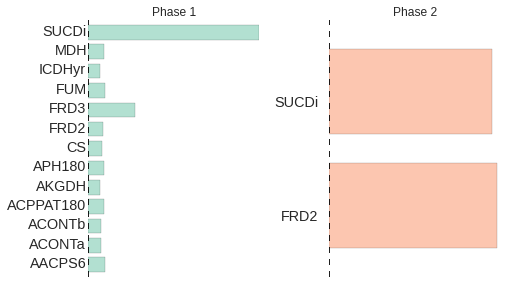

In [91]:
##########################################################
name_graph = 'Reaction_zscores_culture_conditions'
    
fig, axes = plt.subplots(nrows=1, ncols=2)  # change for adding in bis
c1, c2 = sns.color_palette("Set2", 2)

strain = "p1"
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74]
    
#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[0], kind='barh', color=c1, title="Phase 1",alpha=0.5,figsize=(5, 7))
axes[0].axis('off')

for i, x in enumerate(df.reaction):
        axes[0].text(-0.25, i + .5, x, ha='right', fontsize='large')
        #axes[0,0].text(df.zscore.tolist()[i], i + .35, str(np.round(df.zscore.tolist()[i], decimals=2)), ha='right', fontsize='large')

strain = 'p2'
df = DF_reaction_zscore[strain][~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74]

#sns.kdeplot(df_tmp2[r], shade=True, color=c3, alpha=0.7,ax=axes[0,0],label='phase 2')
df.z_score.plot(ax=axes[1], kind='barh', color=c2, title="Phase 2",alpha=0.5,figsize=(5, 7))
axes[1].axis('off')
for i, x in enumerate(df.reaction):
        axes[1].text(-0.25, i + .5, x, ha='right', fontsize='large')
     
fig.tight_layout()

fig = plt.gcf()
fig.set_figwidth(7)
fig.set_figheight(4)

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')

In [77]:
m.reactions.get_by_id(df.reaction.values[0]).subsystem

'Citric Acid Cycle'

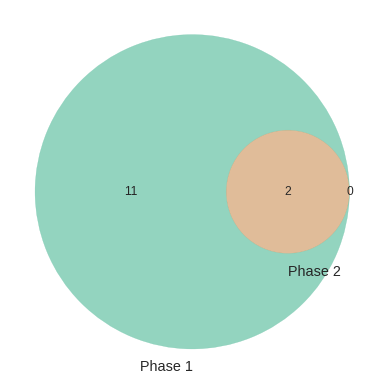

In [78]:
# Veen figures

from matplotlib_venn import venn2, venn2_circles

name_graph = 'Overlaps_reaction_z_score_culture_conditions'

#fig, axes = plt.subplots(nrows=1, ncols=3)  # change for adding in bis
fig = plt.figure()
c1, c2 = sns.color_palette("Set2", 2)


ax1=fig.add_subplot(1,1,1)

strain = 'p1'
set1 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74].tolist()
set1 = set(set1)

strain = 'p2'
set2 = DF_reaction_zscore[strain].reaction[~DF_reaction_zscore[strain].reaction.str.contains('ex')][~DF_reaction_zscore[strain].reaction.str.contains('EX')][~DF_reaction_zscore[strain].reaction.str.contains('pp')][DF_reaction_zscore[strain].z_score > 1.74].tolist()
set2 = set(set2)

v = venn2([set1, set2], ('Phase 1', 'Phase 2'),ax=ax1)
v.get_patch_by_id('100').set_alpha(0.7)
v.get_patch_by_id('100').set_color(c1)
v.get_patch_by_id('010').set_alpha(0.7)
v.get_patch_by_id('010').set_color(c2)

ax1.axis('off')

fig.tight_layout()
fig = plt.gcf()

fig.savefig('%s.pdf'%str(name_graph),dpi=600,format='PDF')
fig.savefig('%s.png'%str(name_graph),dpi=300,format='PNG')